# Trade Execution - Predicting Shortfall

## Introduction
Within finance, an optimal trade execution strategy can enhance a portfolio’s performance by
by using short-term expectations of stock price movements to optimally time a trade.
However, it is difficult to capture all of the idiosyncratic causes of stock price changes in the short term. Alpha profiling, which uses the past behavior of portfolio managers
(PMs) to learn patterns about optimal trade executions (The Trade, 2014), seeks to indirectly
capture the idiosyncratic market beliefs using the PMs historical trading strategy.

A webpage version will be available at
https://github.com/silkeherold/probprog-finalproject/final-project/....

In [106]:
%matplotlib inline
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import scipy.stats as sps

from edward.models import Bernoulli,MultivariateNormalTriL, Normal, Empirical
from edward.util import rbf
from tensorflow.contrib.distributions import bijectors


plt.style.use('ggplot')

In [3]:
ed.set_seed(42)

## Data Overview

The dataset is comprised of the following colums:

* Implementation Shortfall (bps) R
* Expected Cost (bps) R+
* Trade Amount ($), negative indicates sells R
* Forecast Participation Rate (%) R+
* Stock Volatility R+
 * 5 day, 10 day
* Momentum R
 * Open, 5 Day, 10 Day
    
The goal is to predict the deviation between implementation shortfall (actual cost) and expected costs. These deviations are largely influenced by underlying price changes in the market. The model is split into two components: direction and magnitude.

<b>Magnitude</b>

This is a regression problem, which will indicate how large of an absolute deviation will occur. Moves in underlying prices are largely dependent on the trade size, security volatility, and absolute momentum strength. They are also influenced by external idiosynractic events, which are not covered here.

<b>Direction</b>

This is a classification problem that will determine whether the deviation will be positive or not. A positive deviation indicates that the execution cost is more expensive than predicted. These deviations are mostly driven by short-term price moves. The direction of short-term price moves is modeled using the momentum components, which indicate the extent that a price has been increasing or in recent history. 

Number of data points: 911
Number of magnitude features: 7
Number of direction features: 3


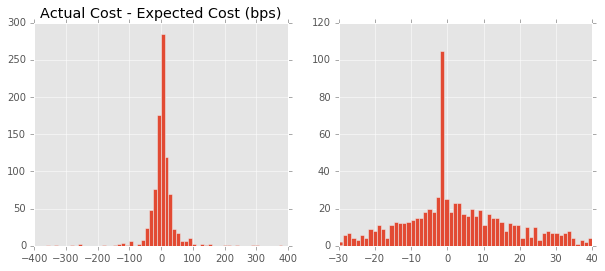

In [93]:
data = np.loadtxt('data/train_data.csv', delimiter=',',skiprows=1)

# Data Size
N = data.shape[0]  # number of data points
D_size = data.shape[1]-2  # number of features
D_dir = data.shape[1]-2-4  # number of features
print("Number of data points: {}".format(N))
print("Number of magnitude features: {}".format(D_size))
print("Number of direction features: {}".format(D_dir))

# Cost Deviation
y_train = data[:, 0]-data[:,1]  # IS - EC

# Histograms of y variable
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Actual Cost - Expected Cost (bps)')
_ = plt.hist(y_train,bins=60)
plt.subplot(1,2,2)
_ = plt.hist(y_train,bins=60,range=(-30, 40))

## 1. Magnitude
### Data

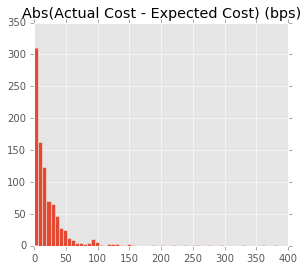

In [94]:
# Magnitude Training Data
X_train_size = np.absolute(data[:, 2:])
y_train_size = np.absolute(data[:, 0]-data[:,1])

# Histograms of y variable
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Abs(Actual Cost - Expected Cost) (bps)')
_ = plt.hist(y_train_size,bins=60)


### Model - Bayesian Linear Regression



In [51]:
ds = tf.contrib.distributions

X_size = tf.placeholder(tf.float32, [N, D_size]) 
w_size = Normal(loc=tf.zeros(D_size), scale=tf.ones(D_size)) 
b_size = Normal(loc=tf.zeros(1), scale=tf.ones(1)) 
y = Normal(loc=ed.dot(X_size, w_size) + b_size, scale=tf.ones(N)) 
y_size = ed.transform(y,bijectors.Exp())


#y_size = ln.parameters(loc=ed.dot(X_size, w_size) + b_size, scale=tf.ones(N)) 

AttributeError: module 'edward' has no attribute 'transform'

### Inference

Perform variational inference.
Define the variational model to be a fully factorized normal.

In [ ]:
qw = Normal(loc=tf.Variable(tf.random_normal([D_size])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D_size]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

inference = ed.KLqp({w_size: qw, b_size: qb}, data={X_size: X_train_size, y_size: y_train_size})
inference.initialize(n_iter=10000)


Run variational inference for `500` iterations.

In [ ]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
curve = []
for _ in range(inference.n_iter):
    status = inference.update()
    if _%1000 == 0:
        print(status)
    curve.append(status['loss'])
_=plt.semilogy(curve)

In this case
`KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp).
(This example happens to be slow because evaluating and inverting full
covariances in Gaussian processes happens to be slow.)

## 2. Direction
### Data




In [95]:
X_train_dir = data[:, 6:]
y_train_dir = data[:, 0]-data[:,1]
# Convert to Classification
y_train_dir[y_train_dir[:] > 0] = 1  
y_train_dir[y_train_dir[:] < 0] = 0

### Model - GP Classification

In [96]:
X_dir = tf.placeholder(tf.float32, [N, D_dir])
f_dir = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X_dir)+0.00001*np.eye(N)))
y_dir = Bernoulli(logits=f_dir)

### Inference

In [97]:
qf_dir = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

In [98]:
inference_dir = ed.KLqp({f_dir: qf_dir}, data={X_dir: X_train_dir, y_dir: y_train_dir})
inference_dir.initialize(n_iter=10000)

{'t': 1, 'loss': 94397672.0}
{'t': 2001, 'loss': 33679.133}
{'t': 4001, 'loss': 20169.33}
{'t': 6001, 'loss': 19990.178}
{'t': 8001, 'loss': 17713.289}


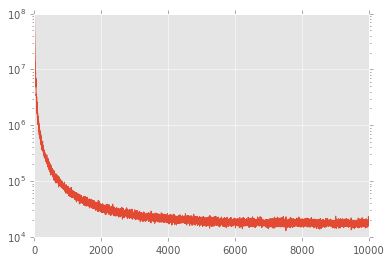

In [99]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
curve = []
for _ in range(inference_dir.n_iter):
    status = inference_dir.update()
    if _%2000 == 0:
        print(status)
    curve.append(status['loss'])
_=plt.semilogy(curve)

In [104]:
y_post_dir = ed.copy(y_dir,{f_dir:qf_dir})

In [105]:
print("Categorical Accuracy")
ed.evaluate('categorical_accuracy', data={y_post_dir: y_train_dir, X_dir: X_train_dir})

#print("Mean squared error on test data:")
#ed.evaluate('mean_squared_error',data={X_dir: X_train_dir, y_post_dir: y_train_dir})

#print("Mean absolute error on test data:")
#ed.evaluate('mean_absolute_error',data={X_dir: X_train_dir, y_post_dir: y_train_dir})

Categorical Accuracy


0.70911086